### Look at: what is the relationship between residual R^2 and partial R^2?
Would expect them to be equal, if not very correlated

### CURRENT STATUS:
- Getting negative partial R^2s, implying R^2 of model without values > R^2 model with values. Don't know how this is possible. 
- In the full regression case also sometimes getting negative scores. 

In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)

In [4]:
OUTPUT_DIR = "/data/patrick_res/glm_2"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)

In [5]:
positions = spike_utils.get_unit_positions(sessions)

### Load residual models

In [6]:
fb_type = "Response"

def load_glm(session, res_name):
    res = pd.read_pickle(os.path.join(OUTPUT_DIR, res_name))
    res["TimeIdxs"] = (res["TimeBins"] * 20).astype(int)
    res["session"] = session
    res["PseudoUnitID"] = int(session) * 100 + res.UnitID
    return res


def get_residual_glm_res(session):
    # res_name = f"{session}_glm_{fb_type}_residual_fr_{MODE}_{INTERVAL_SIZE}_{MODEL}_values.pickle"
    res_name = f"{session}_glm_{fb_type}_residual_fr_{EVENT}_{MODE}_{INTERVAL_SIZE}_{MODEL}_values.pickle"
    res = load_glm(session, res_name)
    res = res.rename(columns={"score": "residual_score"})
    return res

In [7]:
residual_glm_res = pd.concat(sessions.apply(lambda x: get_residual_glm_res(x.session_name), axis=1).values)

In [8]:
merged = pd.merge(residual_glm_res, positions, on="PseudoUnitID")
merged[merged.residual_score > 0.1].groupby("structure_level2").PseudoUnitID.nunique()

structure_level2
anterior_cingulate_gyrus (ACgG)           5
basal_ganglia (BG)                        7
extrastriate_visual_areas_2-4 (V2-V4)     2
inferior_temporal_cortex (ITC)           14
lateral_and_ventral_pallium (LVPal)       4
lateral_prefrontal_cortex (lat_PFC)      14
motor_cortex (motor)                      1
orbital_frontal_cortex (OFC)              2
superior_parietal_lobule (SPL)            4
thalamus (Thal)                           2
Name: PseudoUnitID, dtype: int64

### Load and calculate partial r^2

In [7]:
def get_additional_score(session):
    with_vals_path = f"{session}_glm_RPEGroup_normal_fr_{MODE}_{INTERVAL_SIZE}_{MODEL}_values.pickle"
    with_vals_res = load_glm(session, with_vals_path)
    with_vals_res = with_vals_res.rename(columns={"score": "with_vals_score"})
    coefs = [col for col in with_vals_res.columns if "_coef" in col]

    without_vals_path = f"{session}_glm_{MODE}_{INTERVAL_SIZE}_{MODEL}_feature_rpe_interaction.pickle"
    without_vals_res = load_glm(session, without_vals_path)
    without_vals_res = without_vals_res.rename(columns={"score": "without_vals_score"})

    coefs = [col for col in without_vals_res.columns if "_coef" in col]
    merged = pd.merge(with_vals_res, without_vals_res, on=["PseudoUnitID", "TimeIdxs"])
    merged["additional_score"] = 1 - (1 - merged["with_vals_score"]) / (1 - merged["without_vals_score"])
    # merged["additional_score"] = 
    return merged

In [8]:
partial_reses = pd.concat(sessions.apply(lambda x: get_additional_score(x.session_name), axis=1).values)

In [9]:
merged = pd.merge(partial_reses, residual_glm_res, on=["PseudoUnitID", "TimeIdxs"])
pos_merged = merged[merged.additional_score > 0]

In [10]:
len(pos_merged.PseudoUnitID.unique())

754

In [11]:
print(np.corrcoef(pos_merged.additional_score, pos_merged.residual_score)[0, 1])

0.7400112448441966


Text(0, 0.5, 'residual score')

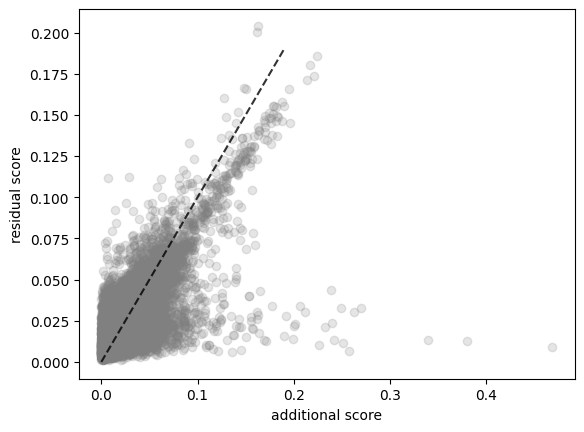

In [12]:
fig, ax = plt.subplots()
ax.scatter(pos_merged.additional_score, pos_merged.residual_score, alpha=0.2, color="gray")
ax.plot(np.arange(0, 0.2, 0.01), np.arange(0, 0.2, 0.01), linestyle="--", color="black", alpha=0.8)
ax.set_xlabel("additional score")
ax.set_ylabel("residual score")


In [10]:
pos_res = pd.merge(residual_glm_res, positions, on="PseudoUnitID")

In [11]:
pos_res[pos_res.residual_score > 0.1].sort_values(by="residual_score", ascending=False).PseudoUnitID

8128         2018092414
11249        2018092115
8129         2018092414
11250        2018092115
1509         2018091811
              ...      
13697        2018071230
86           2018070904
1692         2018091820
15079        2018091027
5749     20180725000131
Name: PseudoUnitID, Length: 294, dtype: int64

In [12]:
# good_units = pos_res.sort_values(by="residual_score", ascending=False)[:200].PseudoUnitID.unique()

In [13]:
# positions[positions.PseudoUnitID.isin(good_units)].manual_structure.unique()

In [14]:
good_units = pos_res[pos_res.residual_score > 0.1].PseudoUnitID.unique()

In [15]:
pos_res[pos_res.residual_score > 0.1].groupby("structure_level2").PseudoUnitID.nunique()

structure_level2
anterior_cingulate_gyrus (ACgG)           5
basal_ganglia (BG)                        7
extrastriate_visual_areas_2-4 (V2-V4)     2
inferior_temporal_cortex (ITC)           14
lateral_and_ventral_pallium (LVPal)       4
lateral_prefrontal_cortex (lat_PFC)      14
motor_cortex (motor)                      1
orbital_frontal_cortex (OFC)              2
superior_parietal_lobule (SPL)            4
thalamus (Thal)                           2
Name: PseudoUnitID, dtype: int64

In [16]:
# good_units = pos_res[(pos_res.structure_level3 == "hippocampal_formation (HF)")]
# good_units = good_units.sort_values(by="residual_score", ascending=False)[:20].PseudoUnitID.unique()

In [26]:
good_units = pos_res[
    (pos_res.residual_score > 0.1) & 
    (pos_res.structure_level2 == "lateral_prefrontal_cortex (lat_PFC)")
].PseudoUnitID.unique()

In [27]:
pos_res[pos_res.PseudoUnitID.isin(good_units)].groupby("session_x").PseudoUnitID.nunique()

session_x
20180705        1
20180709        2
20180712        2
201807250001    2
20180806        2
20180918        1
20180926        1
20180928        1
20181002        1
20181004        1
Name: PseudoUnitID, dtype: int64

In [28]:
good_units

array([    2018070904,     2018070921,     2018091820,     2018100206,
           2018080611,     2018080614, 20180725000116, 20180725000131,
           2018092607,     2018070523,     2018100405,     2018071215,
           2018071230,     2018092804])

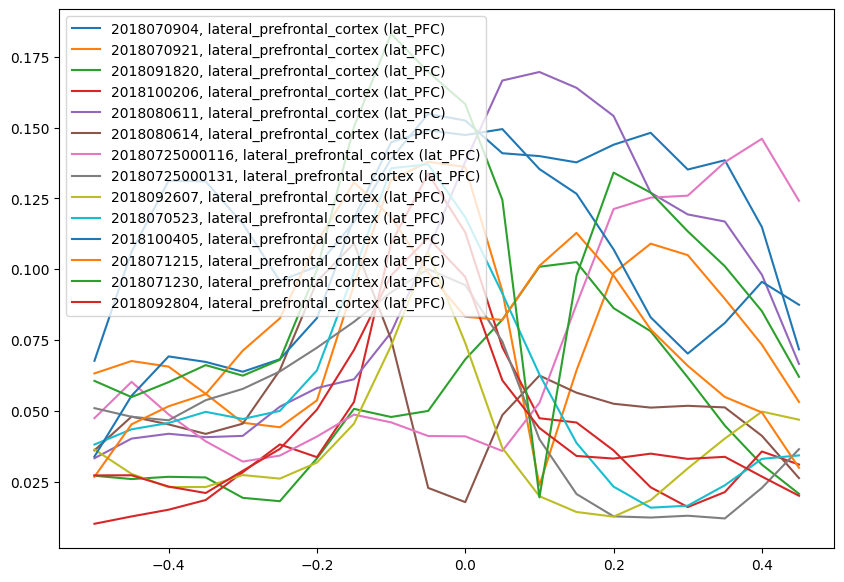

In [29]:
fig, ax = plt.subplots(figsize=(10, 7))
for unit in good_units:
    unit_res = pos_res[pos_res.PseudoUnitID == unit]
    structure =  unit_res.structure_level2.values[0]
    # color = 'red' if structure == "basal_ganglia (BG)" else 'blue'
    ax.plot(unit_res.TimeBins - 0.5, unit_res.residual_score, label=f"{unit}, {structure}")
ax.legend()

In [30]:
unit_res = pos_res[pos_res.PseudoUnitID == 2018080611]

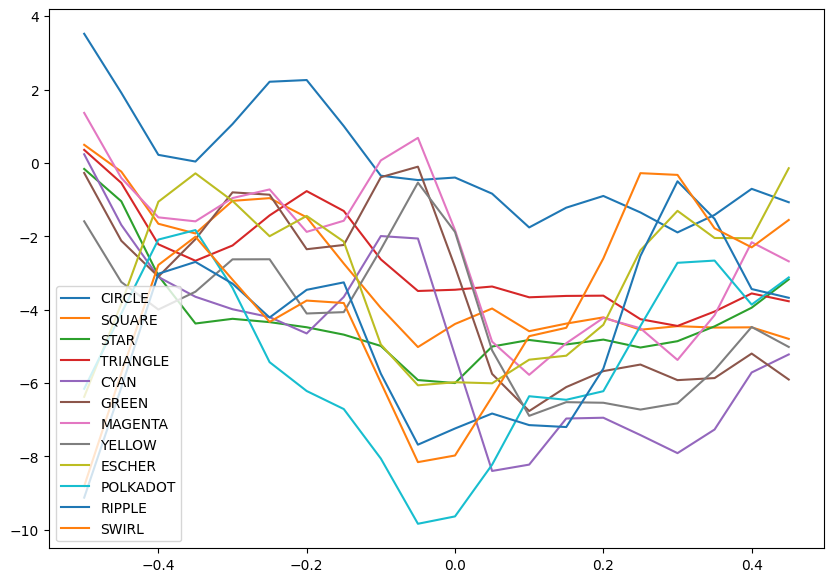

In [31]:
fig, ax = plt.subplots(figsize=(10, 7))
for feat in FEATURES:
    ax.plot(unit_res.TimeBins - 0.5, unit_res[feat + "Value_coef"], label=feat)
ax.legend()

In [35]:
def calc_normed(group):
    session = group.name
    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    valid_beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(valid_beh)
    valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_feature_values_per_session(session, valid_beh)

    return glm_utils.calc_normalized_value_coefs(group, beh)

normed = pos_res.groupby("session_x").apply(calc_normed).reset_index()

/tmp/ipykernel_2416663/2337501274.py:14: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  normed = pos_res.groupby("session_x").apply(calc_normed).reset_index()


In [108]:
len(pos_res[pos_res.structure_level3 == "area_TE (TE)"].PseudoUnitID.unique())

67